# Combine Results from Different Models into a Single Data File

## Preamble

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import numpy as np

import dill

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from cycler import cycler

import sys
sys.path.append('../')
import fluctuations
import twenty_one
import physics as phys

from tqdm.notebook import tqdm

In [3]:
# Load plot settings

from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Abscissa

In [4]:
Tb_data_folder = '/scratch/gpfs/hongwanl/millicharged_DM_with_bath/Vrel_scan_fixed_He_bug/for_Anastasia/'

mm_string_list = ['10_MeV', '30_MeV', '100_MeV', '300_MeV', '1_GeV', '3_GeV', '10_GeV', '30_GeV', '100_GeV', '300_GeV']

Vlis = np.loadtxt(open(Tb_data_folder+'Vlis.csv'), delimiter=',')
Qlis = np.loadtxt(open(Tb_data_folder+'Qlis.csv'), delimiter=',')
# Flipped so that it is in increasing order
zlis = np.flipud(np.loadtxt(open(Tb_data_folder+'zlis.csv'), delimiter=','))

# in GeV
mmlis = np.array([0.01, 0.03, 0.1, 0.3, 1., 3., 10., 30., 100., 300.])

T21_fluc = dill.load(open('/scratch/gpfs/hongwanl/millicharged_DM_with_bath/power_spec/all_models/mc100MeV_full_smooth_deg3_1.p', 'rb'))

## Extract the Global Signal

This cell extracts the global signal from the data files. Run only once. The resulting data file can be loaded and plots made. Something is wrong with model number 136, which gives a bunch of nans, I think because dTK is negative at zlis[0], which doesn't seem right. 

In [5]:
# global_signal_ary = np.zeros((140, 22, 90, 10))

# for idx in tqdm(np.arange(140)): 

#     T21_fluc = dill.load(open('/scratch/gpfs/hongwanl/millicharged_DM_with_bath/power_spec/all_models/mc100MeV_full_smooth_deg3_'+str(idx)+'.p', 'rb'))

#     global_signal = T21_fluc.v_fluc.mean_f(T21_fluc.f_in_v, T21_fluc.v_ary)

#     global_signal_ary[idx, ...] = global_signal 


# dill.dump(global_signal_ary, open('/scratch/gpfs/hongwanl/millicharged_DM_with_bath/power_spec/all_models/global_signal_all_models.p', 'wb'))



### Global Signal Plot

In [6]:
for i in [45, 49, 52, 55, 58, 63]:

    print(Qlis[i])

0.0010807067528039549
0.0020108088432108043
0.003203450204250925
0.005103465327280476
0.008130408367887929
0.01766814729614693


m_m in GeV:  3.0


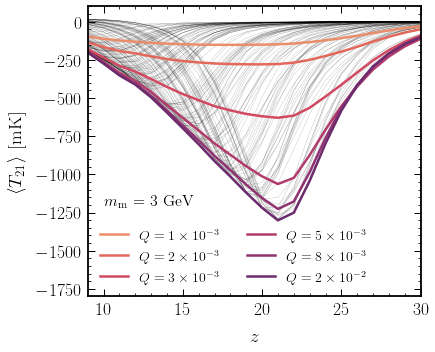

In [7]:
mm_ind = 5

global_signal_ary = dill.load(open('/scratch/gpfs/hongwanl/millicharged_DM_with_bath/power_spec/all_models/global_signal_all_models.p', 'rb'))


print('m_m in GeV: ', T21_fluc.data_dict['m_m'][mm_ind])

plt.figure()

plt.rc('axes', prop_cycle=cycler('color', sns.color_palette('flare', 6)))

palette = sns.color_palette('flare', 6)

plt.xlabel(r'$z$')
plt.ylabel(r'$\langle T_{21} \rangle$ [mK]')

# plt.title(r'\textbf{21-cm Global Signal}')

plt.plot(zlis, np.transpose(global_signal_ary[:, :, 63, mm_ind]) * 1e3, color='k', linewidth=0.1);

plt.gca().set_prop_cycle(None)

plt.plot(zlis, np.nanmin(global_signal_ary[:, :, 45, mm_ind], axis=0) * 1e3, label=r'$Q = 1 \times 10^{-3}$')
plt.plot(zlis, np.nanmin(global_signal_ary[:, :, 49, mm_ind], axis=0) * 1e3, label=r'$Q = 2 \times 10^{-3}$')
plt.plot(zlis, np.nanmin(global_signal_ary[:, :, 52, mm_ind], axis=0) * 1e3, label=r'$Q = 3 \times 10^{-3}$')
plt.plot(zlis, np.nanmin(global_signal_ary[:, :, 55, mm_ind], axis=0) * 1e3, label=r'$Q = 5 \times 10^{-3}$')
plt.plot(zlis, np.nanmin(global_signal_ary[:, :, 58, mm_ind], axis=0) * 1e3, label=r'$Q = 8 \times 10^{-3}$')
plt.plot(zlis, np.nanmin(global_signal_ary[:, :, 63, mm_ind], axis=0) * 1e3, label=r'$Q = 2 \times 10^{-2}$')
plt.plot(zlis, 1e3*np.ones_like(zlis), color=palette[5], linewidth=0.5)

plt.text(x=10, y=-1200, s=r'$m_\mathrm{m}$ = 3 GeV', fontsize=16)

plt.legend(ncol=2, fontsize=14)

plt.xlim(9, 30)
plt.ylim(-1800, 100)

plt.tight_layout()

plt.savefig('plots/global_signal.pdf')

## Extract the Power Spectrum

This cell extracts the power spectra from the data files. Run only once. The resulting data file can be loaded and plots made. 

In [8]:
# power_spec_ary = np.zeros((140, 22, 90, 10))

# for idx in tqdm(np.arange(140)): 

#     T21_fluc = dill.load(open('/scratch/gpfs/hongwanl/millicharged_DM_with_bath/power_spec/all_models/mc100MeV_full_smooth_deg3_'+str(idx)+'.p', 'rb'))

#     k_ary, delta2_ary = T21_fluc.power_spec

#     power_spec_ary[idx, ...] = delta2_ary[1536]


# dill.dump(power_spec_ary, open('/scratch/gpfs/hongwanl/millicharged_DM_with_bath/power_spec/all_models/power_spec_at_0_1_per_Mpc.p', 'wb'))


### Import Power Spectrum Limits

In [9]:
import os
import yaml
import pandas as pd

directory_str = '/home/hongwanl/eor_limits/eor_limits/data/'
directory = os.fsencode('/home/hongwanl/eor_limits/eor_limits/data/')

# k of interest. 
k_ref = 0.1
bounds_df = pd.DataFrame(columns=['telescope', 'author', 'year', 'doi', 'type', 'delta_squared', 'k', 'k_lower', 'k_upper', 'redshift'])
    
for file in os.listdir(directory):
     filename = os.fsdecode(file)
     if filename.split(sep='.')[-1] == 'yaml':
        data = yaml.safe_load(open(directory_str+filename))
        # process the delta_squared data first. 
        processed_delta_squared = []
        # check if the delta_squared list in the yaml file is 2D or 1D. 
        if isinstance(data['delta_squared'][0], list): 
            # it's 2D. iterate over each list in the 2D list.  
            for delta_squared_ary in data['delta_squared']: 
                delta_squared_list = []
                # if it's a float, append it. if it's a string, evaluate it first, unless it's 'nan', in which
                # case, manually append np.nan. 
                for delta_squared in delta_squared_ary:
                    if isinstance(delta_squared, float):
                        delta_squared_list.append(delta_squared)
                    elif delta_squared != 'nan': 
                        delta_squared_list.append(eval(delta_squared))
                    else: 
                        delta_squared_list.append(np.nan)
                processed_delta_squared.append(delta_squared_list)
        else: 
            for delta_squared in data['delta_squared']:
                if delta_squared != 'nan': 
                    processed_delta_squared.append(eval(delta_squared))
                else: 
                    processed_delta_squared.append(np.nan)
        
        if len(data['redshift']) > 1:
            # the redshift list has more than 1 entry.  
            if isinstance(data['redshift'][0], list): 
                # the redshift list contains sublists. 
                for z_idx,z in enumerate(data['redshift']): 
                    for k_idx,k_lower in enumerate(data['k_lower'][z_idx]): 
                        entry = pd.DataFrame.from_dict([{
                            'telescope': data['telescope'],
                            'author': data['author'],
                            'year': data['year'],
                            'doi': data['doi'],
                            'type': data['type'],
                            'delta_squared': processed_delta_squared[z_idx][k_idx],
                            'k': data['k'][z_idx][k_idx],
                            'k_lower': k_lower,
                            'k_upper': data['k_upper'][z_idx][k_idx],
                            'redshift': z[0]
                        }])
                        bounds_df = pd.concat([bounds_df, entry], ignore_index=True)
                        
            else:
                # the redshift list is just a list of redshifts. 
                for k_idx,k_lower in enumerate(data['k_lower']): 
                    entry = pd.DataFrame.from_dict([{
                        'telescope': data['telescope'],
                        'author': data['author'],
                        'year': data['year'],
                        'doi': data['doi'],
                        'type': data['type'],
                        'delta_squared': processed_delta_squared[k_idx],
                        'k': data['k'][k_idx],
                        'k_lower': k_lower,
                        'k_upper': data['k_upper'][k_idx],
                        'redshift': data['redshift'][k_idx]
                    }])
                    bounds_df = pd.concat([bounds_df, entry], ignore_index=True)
        else:
            # only one redshift. 
            for k_idx,k_lower in enumerate(data['k_lower']): 
                entry = pd.DataFrame.from_dict([{
                    'telescope': data['telescope'],
                    'author': data['author'],
                    'year': data['year'],
                    'doi': data['doi'],
                    'type': data['type'],
                    'delta_squared': processed_delta_squared[k_idx],
                    'k': data['k'][k_idx],
                    'k_lower': k_lower,
                    'k_upper': data['k_upper'][k_idx],
                    'redshift': data['redshift'][0]
                }])
                bounds_df = pd.concat([bounds_df, entry], ignore_index=True)

rel_bounds_df = bounds_df[(bounds_df['k_lower'] < k_ref) & (bounds_df['k_upper'] > k_ref)]
rel_bounds_df = rel_bounds_df.drop(labels=[315, 316, 317, 323, 324, 325, 331, 332, 333])
print(rel_bounds_df)


       telescope    author  year                         doi   type  \
51       MWA 32T    Dillon  2014  10.1103/PhysRevD.89.023002  point   
52       MWA 32T    Dillon  2014  10.1103/PhysRevD.89.023002  point   
53       MWA 32T    Dillon  2014  10.1103/PhysRevD.89.023002  point   
55       MWA 32T    Dillon  2014  10.1103/PhysRevD.89.023002  point   
56       MWA 32T    Dillon  2014  10.1103/PhysRevD.89.023002  point   
65          HERA      HERA  2022    10.3847/1538-4357/ac1c78   line   
79          HERA      HERA  2022    10.3847/1538-4357/ac1c78   line   
196        LOFAR   Mertens  2020       10.1093/mnras/staa327   line   
206        LOFAR     Patil  2017    10.3847/1538-4357/aa63e7   line   
211        LOFAR     Patil  2017    10.3847/1538-4357/aa63e7   line   
216        LOFAR     Patil  2017    10.3847/1538-4357/aa63e7   line   
314  MWA phase I  Yoshiura  2021      10.1093/mnras/stab1560  point   
322  MWA phase I  Yoshiura  2021      10.1093/mnras/stab1560  point   
330  M

Q:  2.2300500321347896e-05
m_m in GeV:  3.0
k in Mpc^-1:  0.10028091636980907


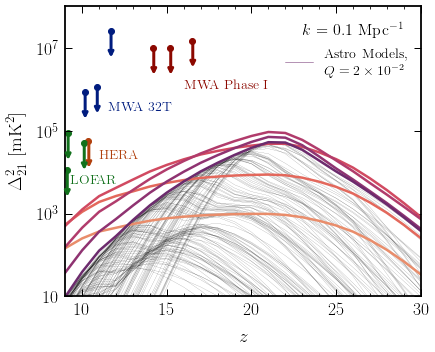

In [10]:
power_spec_ary = dill.load(open('/scratch/gpfs/hongwanl/millicharged_DM_with_bath/power_spec/all_models/power_spec_at_0_1_per_Mpc.p', 'rb'))

plt.rc('axes', prop_cycle=cycler('color', sns.color_palette('flare', 6)))

palette = sns.color_palette('flare', 6)

k_ary, delta2_ary = T21_fluc.power_spec

print('Q: ', T21_fluc.data_dict['Q'][20])
print('m_m in GeV: ', T21_fluc.data_dict['m_m'][mm_ind])
print('k in Mpc^-1: ', k_ary[1536])

plt.figure()

plt.yscale('log')

plt.xlabel(r'$z$')
plt.ylabel(r'$\Delta_{21}^2$ [mK$^2$]')

# plt.title(r'\bf{21-cm Power Spectrum}')

plt.plot(zlis, np.transpose(power_spec_ary[:, :, 63, mm_ind]) * 1e6, color='k', linewidth=0.1);

ax = plt.gca()
ax.set_prop_cycle(None)
# plt.plot(zlis, np.nanmax(power_spec_ary[:, :, 20, mm_ind], axis=0) * 1e6, label=r'$Q = 2 \times 10^{-5}$')
# plt.plot(zlis, np.nanmax(power_spec_ary[:, :, 28, mm_ind], axis=0) * 1e6, label=r'$Q = 8 \times 10^{-5}$')
# plt.plot(zlis, np.nanmax(power_spec_ary[:, :, 36, mm_ind], axis=0) * 1e6, label=r'$Q = 3 \times 10^{-4}$')
# plt.plot(zlis, np.nanmax(power_spec_ary[:, :, 44, mm_ind], axis=0) * 1e6, label=r'$Q = 9 \times 10^{-4}$')
# plt.plot(zlis, np.nanmax(power_spec_ary[:, :, 52, mm_ind], axis=0) * 1e6, label=r'$Q = 3 \times 10^{-3}$')
# plt.plot(zlis, np.nanmax(power_spec_ary[:, :, 60, mm_ind], axis=0) * 1e6, label=r'$Q = 10^{-2}$')
# plt.plot(zlis, np.nanmax(power_spec_ary[:, :, 45, mm_ind], axis=0) * 1e6, label=r'$Q = 2 \times 10^{-2}$')

plt.plot(zlis, np.nanmax(power_spec_ary[:, :, 45, mm_ind], axis=0) * 1e6)
plt.plot(zlis, np.nanmax(power_spec_ary[:, :, 49, mm_ind], axis=0) * 1e6)
plt.plot(zlis, np.nanmax(power_spec_ary[:, :, 52, mm_ind], axis=0) * 1e6)
plt.plot(zlis, np.nanmax(power_spec_ary[:, :, 55, mm_ind], axis=0) * 1e6)
plt.plot(zlis, np.nanmax(power_spec_ary[:, :, 58, mm_ind], axis=0) * 1e6)
plt.plot(zlis, np.nanmax(power_spec_ary[:, :, 63, mm_ind], axis=0) * 1e6)
plt.plot(zlis, 0*np.ones_like(zlis), color=palette[5], linewidth=0.5, label=r'Astro Models,'+'\n'+r'$Q = 2 \times 10^{-2}$')

palette = sns.color_palette('dark')

color_dict = {'MWA 32T': palette[0], 'HERA': palette[1], 'LOFAR': palette[2], 'MWA phase I': palette[3]}

for z,delta_squared,tele in zip(
    rel_bounds_df['redshift'], rel_bounds_df['delta_squared'], rel_bounds_df['telescope']
):

    plt.scatter(z, delta_squared, color=color_dict[tele], linewidth=1)

    ax.annotate(
        "", xy=(z*1.002, delta_squared), 
        xytext=(z*1.002, delta_squared/5),
        arrowprops=dict(arrowstyle="<-", color=color_dict[tele], linewidth=3)
    )

# plt.text(x=10, y=3e5, s=r'$m_\mathrm{m}$ = 3 GeV', fontsize=16)
plt.text(x=23, y=2e7, s=r'$k$ = 0.1 Mpc$^{-1}$', fontsize=16)

plt.text(x=11.5, y=3e5, s='MWA 32T', fontsize=14, color=palette[0])
plt.text(x=11, y=2e4, s='HERA', fontsize=14, color=palette[1])
plt.text(x=9.3, y=5e3, s='LOFAR', fontsize=14, color=palette[2])
plt.text(x=16, y=1e6, s='MWA Phase I', fontsize=14, color=palette[3])

plt.legend(ncol=2, fontsize=14, loc='upper right', bbox_to_anchor=(1, 0.9))

plt.axis([9, 30, 10, 1e8])

plt.tight_layout()

plt.savefig('plots/power_spec.pdf')

## Global Signal vs. Power Spectrum

z:  17.0
0.0020108088432108043 0.005103465327280476 0.011090313431155938 0.02063510777876421 0.05237223688824735 0.09744600632908472
1.0
1.0 0.0020108088432108043
1.0 0.005103465327280476
1.0 0.011090313431155938
1.0 0.02063510777876421
3.0 0.0020108088432108043
3.0 0.005103465327280476
3.0 0.011090313431155938
3.0 0.02063510777876421
3.0 0.05237223688824735
3.0 0.09744600632908472
10.0 0.0020108088432108043
10.0 0.005103465327280476
10.0 0.011090313431155938
10.0 0.02063510777876421
10.0 0.05237223688824735
10.0 0.09744600632908472
30.0 0.0020108088432108043
30.0 0.005103465327280476
30.0 0.011090313431155938
30.0 0.02063510777876421
30.0 0.05237223688824735
30.0 0.09744600632908472
100.0 0.005103465327280476
100.0 0.011090313431155938
100.0 0.02063510777876421
100.0 0.05237223688824735
100.0 0.09744600632908472
300.0 0.005103465327280476
300.0 0.011090313431155938
300.0 0.02063510777876421
300.0 0.05237223688824735
300.0 0.09744600632908472


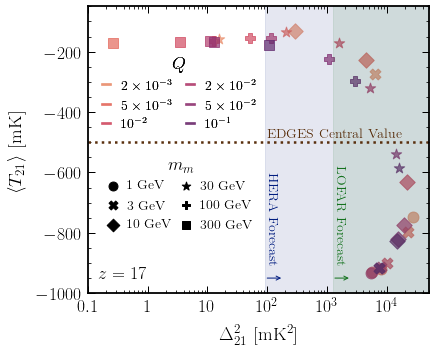

In [11]:
z_ind = 8

print('z: ', T21_fluc.data_dict['z'][z_ind])

# Create the global signal vs. power spectrum array at fixed z. Dimensions 140 x 90 x 10 x 2
glob_vs_ps_ary = np.transpose([global_signal_ary[:, z_ind, :, :], power_spec_ary[:, z_ind, :, :]], axes=(1, 2, 3, 0))

plt.figure()

plt.xscale('log')

# Starting plotting from 100 MeV. Lower bound from our paper, Upper bound from combination of
# ArgoNeut (1911.07996), Super-K (2002.11732) and colliders from our paper. 

Q_min_ary = [0., 0., 5.22e-5, 9.63e-5, 1.86e-4, 3.44e-4, 6.66e-4, 1.26e-3, 2.38e-3, 4.39e-3, 8.706e-3]
Q_max_ary = [0., 0., 0.0033, 0.0067, 0.02075, 0.116, 0.237, 0.237, 0.315, 0.625]


Q_min_ind = np.argwhere(Qlis > Q_min_ary[mm_ind]).flatten()[0]
Q_max_ind = np.argwhere(Qlis < Q_max_ary[mm_ind]).flatten()[-1]

ax = plt.gca()

# Pick an example model which has a large power spectrum and global signal. 
model_ind = 36

# These are the Q indices to plot. 
Q_indices_to_plot = [49, 55, 60, 64, 70, 74]
print(Qlis[49], Qlis[55], Qlis[60], Qlis[64], Qlis[70], Qlis[74])
# This is the minimum m_m to start at (1 GeV). 
print(mmlis[4])

# Markers for m_m >= 1 GeV. 
marker_list = [ 'o', 'X', 'D', '*', 'P', 's']
# Palette for Q to plot. 
palette = sns.color_palette('flare', 6)

for i,_ in enumerate(mmlis):

    # Obtain the minimum and maximum Qlis indices which are experimentally allowed. 
    try: 
        Q_min_ind = np.argwhere(Qlis > Q_min_ary[i]).flatten()[0]
        Q_max_ind = np.argwhere(Qlis < Q_max_ary[i]).flatten()[-1]
    except:
        continue

    if i < 4: 
        continue

    # pt is which charge from 1 -- 6 to plot. j is the actual index of the charge in Qlis. 
    for pt,j in enumerate(Q_indices_to_plot):

        if j >= Q_min_ind and j <= Q_max_ind:
            # This value of Q, i.e. Qlis[j], is allowed. 
            print(mmlis[i], Qlis[j])

            plt.scatter(np.nanmax(glob_vs_ps_ary[model_ind,j,i,1]*1e6, axis=0), np.nanmin(glob_vs_ps_ary[:,j,i,0]*1e3, axis=0), marker=marker_list[i-4], s=120, color=palette[pt], alpha=0.7)

        else:

            plt.scatter([0], [0])

plt.xlim(1, 5e4)

palette = sns.color_palette('dark')

# Taken from Julian's millicharged paper, and EDGES = -500 mK central value. 
plt.axhline(-500, color=palette[5], linestyle=':')
ax.fill_betweenx((-1e4, 1e4), 92.7, 1e6, color=palette[0], alpha=0.1)
ax.fill_betweenx((-1e4, 1e4), 1255, 1e6, color=palette[2], alpha=0.1)

plt.text(x=92.7, y=-900, s='HERA Forecast', fontsize=14, color=palette[0], rotation=-90)
plt.text(x=1255, y=-900, s='LOFAR Forecast', fontsize=14, color=palette[2], rotation=-90)
plt.text(x=1e2, y=-485, s='EDGES Central Value', fontsize=14, color=palette[5])
plt.text(x=0.15,  y=-950, s=r'$z = 17$', fontsize=18, color='k')
ax.annotate(
    "", xy=(92.7, -950), 
    xytext=(92.7*2, -950),
    arrowprops=dict(arrowstyle="<-", color=palette[0], linewidth=1)
)
ax.annotate(
    "", xy=(1255, -950), 
    xytext=(1255*2, -950),
    arrowprops=dict(arrowstyle="<-", color=palette[2], linewidth=1)
)

plt.xlabel(r'$\Delta_{21}^2$ [mK$^2$]')
plt.ylabel(r'$\langle T_{21} \rangle$ [mK]')

mm_str_list = ['1 GeV', '3 GeV', '10 GeV', '30 GeV', '100 GeV', '300 GeV']
Q_str_list = [r'$2 \times 10^{-3}$', r'$5 \times 10^{-3}$', r'$10^{-2}$', r'$2 \times 10^{-2}$', r'$5 \times 10^{-2}$', r'$10^{-1}$']

mm_handles_list = []
Q_handles_list = []

# Make the fake plots for the legends. 
for i,_ in enumerate(mm_str_list):

    to_plot, = plt.plot([0], [0], label=Q_str_list[i], alpha=0.7)
    Q_handles_list.append(to_plot)

for i,marker in enumerate(marker_list): 

    scat = ax.scatter([0, 0], [0, 0], label=mm_str_list[i], marker=marker, color='k', s=80)
    mm_handles_list.append(scat)

legend1 = plt.legend(handles=mm_handles_list, ncol=2, fontsize=14, handlelength=.4, title=r'$m_m$', title_fontsize=18, columnspacing=0.8, bbox_to_anchor=(0.52, 0.52))
legend2 = plt.legend(handles=Q_handles_list, ncol=2, fontsize=14, handlelength=.6, title=r'$Q$', title_fontsize=18, columnspacing=1, bbox_to_anchor=(0.53, 0.87))

ax.add_artist(legend1)

ax.add_artist(legend2)

plt.axis([.1, 5e4, -1000, -50])

plt.tight_layout()

plt.savefig('plots/global_signal_vs_power_spec.pdf')

## Maximum Power Spectrum

In [12]:
# max_power_spec_ary = []

# for idx in tqdm(np.arange(140)): 

#     T21_fluc = dill.load(open('/scratch/gpfs/hongwanl/millicharged_DM_with_bath/power_spec/all_models/mc100MeV_full_smooth_deg3_'+str(idx)+'.p', 'rb'))

#     # delta2_ary has dimensions 4096 x 22 x 90 x 10, k_ary x zlis x Qlis x mmlis
#     k_ary, delta2_ary = T21_fluc.power_spec

#     for i,mm in enumerate(mmlis): 

#         if i < 4: 
#         # Only consider 1 GeV and above. 
#             continue

#         # Obtain the minimum and maximum Qlis indices which are experimentally allowed. 
#         try: 
#             Q_min_ind = np.argwhere(Qlis > Q_min_ary[i]).flatten()[0]
#             Q_max_ind = np.argwhere(Qlis < Q_max_ary[i]).flatten()[-1]
#         except:
#             continue

#         # Find the maximum power spectrum value over all k, z. 
#         max_power_spec = np.nanmax(delta2_ary[:, :, Q_min_ind:Q_max_ind+1, i], axis=2)
#         # Take the element-wise maximum with the existing table and this particular model point.
#         max_power_spec_ary.append(max_power_spec)

# dill.dump(max_power_spec_ary, open('/scratch/gpfs/hongwanl/millicharged_DM_with_bath/power_spec/all_models/max_power_spec.p', 'wb'))

In [13]:
# has dimensions 1120 x 4096 x 22, the first dimension is a combination of some values of m_m x astro models. 
max_power_spec_ary = np.array(dill.load(open('/scratch/gpfs/hongwanl/millicharged_DM_with_bath/power_spec/all_models/max_power_spec.p', 'rb')))

T21_fluc = dill.load(open('/scratch/gpfs/hongwanl/millicharged_DM_with_bath/power_spec/all_models/mc100MeV_full_smooth_deg3_1.p', 'rb'))


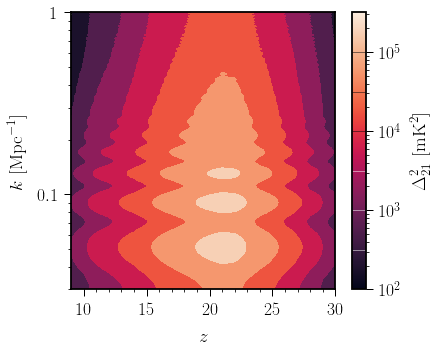

In [14]:
from matplotlib import colors
from matplotlib import cm


# delta2_ary has dimensions 4096 x 22 x 90 x 10, k_ary x zlis x Qlis x mmlis
k_ary, delta2_ary = T21_fluc.power_spec


plt.figure()

plt.ylim(3e-2, 1)
plt.yscale('log')

plt.xlabel(r'$z$')
plt.ylabel(r'$k$ [Mpc$^{-1}$]')


# cplot = plt.contour(zlis, k_ary, np.nanmax(max_power_spec_ary, axis=0)*1e6, levels=[1e3, 10**(3.5), 1e4, 10**(4.5), 1e5], locator=ticker.LogLocator(), cmap='flare')

# fmt = {}

# strs = [r'$10^3$', r'$10^{3.5}$', r'$10^4$', r'$10^{4.5}$', r'$10^5$']

# for l, s in zip(cplot.levels, strs): 
    
#     fmt[l] = s

ax = plt.gca()

data = np.nanmax(max_power_spec_ary, axis=0)*1e6
data[data < 0] = 1e-100

cplot = ax.contourf(zlis, k_ary, data, [1e2, 10**(2.5), 1e3, 10**(3.5), 1e4, 10**(4.5), 1e5, 10**(5.5)], cmap='rocket', norm=colors.LogNorm())


ax.tick_params(axis='x', direction='out', which='both', top=False)
ax.tick_params(axis='y', direction='out', which='both', right=False)

# ax.tick_params(axis='y', colors='w', which='both')
# plt.setp(ax.get_yticklabels(), color='k')

cbar = plt.colorbar(cm.ScalarMappable(norm=colors.LogNorm(vmin=1e2, vmax=10**(5.5)), cmap='rocket'), ax=ax)
cbar.set_label(r'$\Delta_{21}^2$ [mK$^2$]')
cbar.ax.plot([0,1], [10**(2.5), 10**(2.5)], 'w', linewidth=0.5)
cbar.ax.plot([0,1], [10**(3), 10**(3)], 'w', linewidth=0.5)
cbar.ax.plot([0,1], [10**(3.5), 10**(3.5)], 'w', linewidth=0.5)
cbar.ax.plot([0,1], [10**(4), 10**(4)], 'k', linewidth=0.5)
cbar.ax.plot([0,1], [10**(4.5), 10**(4.5)], 'k', linewidth=0.5)
cbar.ax.plot([0,1], [10**(5), 10**(5)], 'k', linewidth=0.5)
cbar.ax.tick_params(axis='y', direction='out', which='both')

plt.tight_layout()

plt.savefig('plots/max_power_spec.pdf')